# 使用DMT训练框架

通过以下4步，使用DMT框架训练并使用你自己的深度学习模型：
1. 定义数据集
2. 定义模型
3. 重写训练器和测试方法
4. 编写配置文件

## 1. 定义数据集

DMT 框架使用 `torch.utils.data.Dataset` 作为数据集的基类，唯一的限制是你只能通过传入一个 `EasyDict` 实例 `args` 参数来实例化数据集。

例如在 `src_classify` 中，我们使用一个封装好的 MNIST 数据集，它带有两个自定义方法 `transforms` 和 `inv_transforms` 对数据进行归一化和逆归一化。

Text(0.5, 1.0, 'Label: 6')

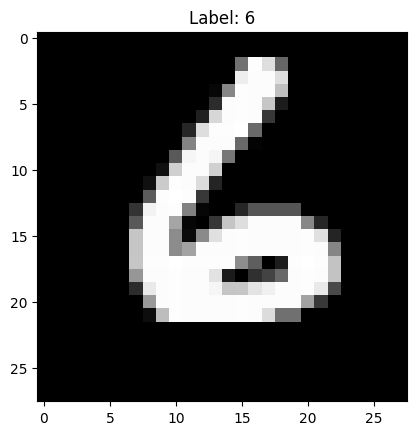

In [15]:
from easydict import EasyDict
from src_classify.datasets import MNIST

args_data = EasyDict(dict(root = "data", train = True))
ds = MNIST(args_data)

import random
index = random.randint(0, len(ds))
img, label = ds.inv_transforms()(ds[index][0]), ds[index][1]

import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(f"Label: {label}")


## 2. 定义模型

DMT 框架使用 `torch.nn.Module` 作为模型的基类，同样的，你只能通过传入一个 `EasyDict` 实例 `args` 参数来实例化模型。

例如在 `src_classify` 中，我们使用一个封装好的 ResNet 模型。它带有两个自定义方法 `compute_loss` 和 `predict` 分别用来在训练阶段计算损失函数和在测试阶段进行预测。

In [ ]:
from src_classify.models import ResnetModel

args_model = EasyDict(dict(
    input=1, output=10, hidden_dims=[32, 64, 128]
))
model = ResnetModel(args_model)

## 3. 重写训练器和测试方法

DMT框架使用自定义的 `Trainer` 作为训练器的基类，你需要继承它编写自己的训练器，并重写以下方法：
- 必须重写的方法：
  - `_compute_loss`：计算损失函数，返回两个字典分别记录损失函数的值和相应的权值超参数
  - `_register_custom_metrics`：将自定义的指标名称登录到 `self.tracker` 中
- 按需求重写的方法：
  - `eval`: 在测试模式下需要重写，用来计算测试集上的指标
  - `_eval_epoch`：在训练过程中计算测试指标的方法
  - `_log_metrics`：在 `_eval_epoch` 后将测试指标写入日志文件的方法
  - `sample`：在采样模式下需要重写，用来生成新样本
  - `_sample_epoch`：在训练过程中生成新样本的方法

例如在 `src_classify` 中，我们使用 `ClassifyTrainer` 作为训练器。

## 4. 编写配置文件

DMT框架使用 *.yml* 文件对实验进行配置，配置文件分为7个部分：
1. 实验信息：包括名称、os、gpu等信息
2. 模型参数
3. 数据集参数
4. 训练过程参数：包括优化器、学习率、训练轮数等
5. 评估过程参数：包括评估批大小等
6. 采样过程参数
7. 其他参数

具体可参考`base_config.yml`文件。

# 例子：使用ResNet对MNIST数据集进行手写数字分类

代码目录：`./src_classify`

- 工作目录: 
    ```bash
    $ pwd
    ~/deep-model-trainer
    ```
- 训练模型
    ```bash
    $ python src_classify/main.py --config base_config --train
    ```
- 断点继续训练
    ```bash
    $ python src_classify/main.py --config base_config --new_config resume --train 
    ```
- tensorboard monitor
    ```bash
    $ tensorboard --logdir experiments/MNIST-Classification/logs --port=8008
    ```

# 例子：使用VQ-VAE对MNIST数据集进行手写数字生成

代码目录：`./src_generate`

- 工作目录: 
    ```bash
    $ pwd
    ~/deep-model-trainer
    ```

multi-gpu evaluate

In [ ]:
!CUDA_VISIBLE_DEVICES="0,1" accelerate launch --num_processes=2 src_example/main.py --config example --eval

sample

In [ ]:
!CUDA_VISIBLE_DEVICES="0,1" accelerate launch --num_processes=2 src_example/main.py --config example --sample

Tensorboard 可视化训练过程

In [ ]:
!tensorboard --logdir experiments/MLP-ExampleDataset/logs --port=8008

In [2]:
import torch 

h = torch.randn(1, 1, 14, 14)

downsample = torch.nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)
h_down = downsample(h)
h_down.shape

torch.Size([1, 1, 7, 7])

In [3]:
upsample = torch.nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, padding=0)
h_hat = upsample(h_down)
h_hat.shape

torch.Size([1, 1, 14, 14])

In [1]:
import torch
from src_generate.models.encoder import Encoder, Decoder

e = Encoder(1, [16, 64, 128], 2)
x = torch.randn(1, 1, 28, 28)
h = e(x)
h.shape

torch.Size([1, 128, 4, 4])

In [7]:
d = Decoder(1, [128, 64, 16], 28)
x_hat = d(h)
x_hat.shape

torch.Size([1, 1, 28, 28])

In [5]:
d

Decoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): UpSampleLayer(
        (_conv_1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (_bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (_bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (_identity): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
      )
      (1): ResidualLayer(
        (_conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (_bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (_conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (_bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (_identity): Identity()
      )
      (2): ResidualLayer(
 

In [6]:
from src_generate.models.encoder import UpSampleLayer, ResidualLayer

upsample = UpSampleLayer(128, 64, 3)
res = ResidualLayer(64, 64, 3)
res(upsample(h)).shape

torch.Size([1, 64, 8, 8])